In [9]:
import csv
import torch
import torchvision
import matplotlib.pyplot as plt
import torch.optim as optim
import numpy as np

from tqdm.auto import tqdm
from pathlib import Path
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, TensorDataset

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device = "cpu"

BATCH_SIZE = 16
IMAGE_SHAPE = (128, 128)
PROCESSED_DATASET_PATH_MNETV1_TRAIN = Path("../../../../dataset/processed/train")
PROCESSED_DATASET_PATH_MNETV1_TEST = Path("../../../../dataset/processed/test/")
PROCESSED_DATASET_PATH_MNETV1_VAL = Path("../../../../dataset/processed/val")


print(device)

cuda:0


In [10]:
train_transform = transforms.Compose([
    transforms.Resize(IMAGE_SHAPE),
    transforms.RandomRotation(10),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

test_transform = transforms.Compose([
    transforms.Resize(IMAGE_SHAPE),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

train_set = datasets.ImageFolder(PROCESSED_DATASET_PATH_MNETV1_TRAIN, transform=train_transform)
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)

val_set = datasets.ImageFolder(PROCESSED_DATASET_PATH_MNETV1_VAL, transform=test_transform)
val_loader = DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)

test_set = datasets.ImageFolder(PROCESSED_DATASET_PATH_MNETV1_VAL, transform=test_transform)
test_loader = DataLoader(test_set, shuffle=True)

print(len(train_set), len(val_set), len(test_set), train_set.classes)

10805 1346 1346 ['antelope', 'cow', 'deer', 'elephant', 'giraffe', 'horse', 'lion', 'rabbit', 'sheep', 'squirrel', 'zebra']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


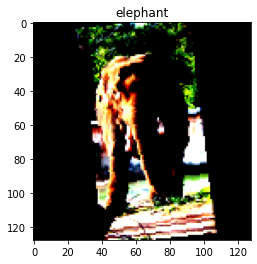

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


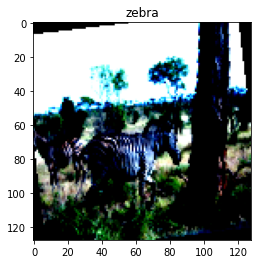

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


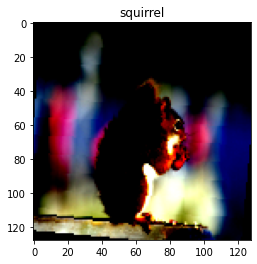

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


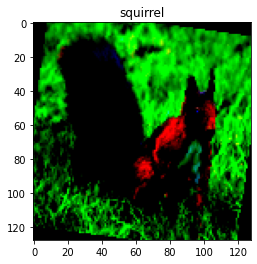

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


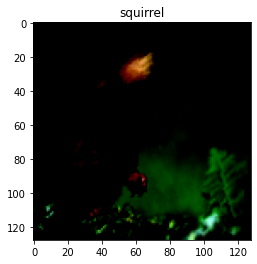

In [11]:
train_loader_vis = torch.utils.data.DataLoader(train_set, 15, shuffle=True)

images, labels = next(iter(train_loader_vis))
images, labels = images.numpy() , labels.numpy()

for i in range(5):
    plt.imshow(np.transpose(images[i] , (1,2,0)))
    plt.title(train_set.classes[labels[i]])
    plt.show()

del images, labels
del train_loader_vis

In [12]:
model = torchvision.models.mobilenet_v2(num_classes=len(train_set.classes), pretrained=False)
model = model.to(device)
model.eval()

MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

In [13]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [14]:
open("./logs/training_logs.csv", "w", newline="")
log_file = open("./logs/training_logs.csv", "a", newline="")
csv_writer = csv.writer(log_file)
csv_writer.writerow(["epoch", "train_loss", "train_acc", "val_loss", "val_acc"])


def loop_fn(mode, dataset, dataloader, model, criterion, optimizer):
    if mode == 'train':
        model.train()
    elif mode == 'val':
        model.eval()
  
    loss = correct = 0
    for feature, target in tqdm(dataloader, desc=mode.title()):
        feature, target = feature.to(device), target.to(device)
        output = model(feature)
        loss = criterion(output, target)

        if mode == 'train':
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        loss += loss.item() * feature.shape[0]
        correct += (output.argmax(1) == target).sum().item()
    loss = loss/len(dataset)
    accuracy = correct/len(dataset)
    return loss, accuracy

num_epochs = 10
try:
    for epoch in range(1, num_epochs + 1):
        train_cost, train_score = loop_fn('train', train_set, train_loader, model, criterion, optimizer)
        with torch.no_grad():
            test_cost, test_score = loop_fn('val', val_set, val_loader, model, criterion, optimizer)
        print(epoch, float(train_cost), train_score, float(test_cost), test_score)
        csv_writer.writerow([epoch, float(train_cost), train_score, float(test_cost), test_score])
        torch.save(model.state_dict(), f"./logs/models/model_e{epoch}.pth")
except Exception as e:
    log_file.close()
    raise e


Train:   0%|          | 0/676 [00:00<?, ?it/s]

Val:   0%|          | 0/85 [00:00<?, ?it/s]

1 0.0011532416101545095 0.2035168903285516 0.0051483712159097195 0.23699851411589895


Train:   0%|          | 0/676 [00:00<?, ?it/s]

Val:   0%|          | 0/85 [00:00<?, ?it/s]

2 0.0007847994565963745 0.25997223507635353 0.003325299359858036 0.2800891530460624


Train:   0%|          | 0/676 [00:00<?, ?it/s]

Val:   0%|          | 0/85 [00:00<?, ?it/s]

3 0.0008361231884919107 0.3116149930587691 0.002945641754195094 0.3789004457652303


Train:   0%|          | 0/676 [00:00<?, ?it/s]

Val:   0%|          | 0/85 [00:00<?, ?it/s]

4 0.001029542414471507 0.35187413234613607 0.004246734548360109 0.3952451708766716


Train:   0%|          | 0/676 [00:00<?, ?it/s]

Val:   0%|          | 0/85 [00:00<?, ?it/s]

5 0.001007063197903335 0.393984266543267 0.0032918902579694986 0.41530460624071325


Train:   0%|          | 0/676 [00:00<?, ?it/s]

Val:   0%|          | 0/85 [00:00<?, ?it/s]

6 0.0012073396937921643 0.431466913465988 0.0021359273232519627 0.4309063893016345


Train:   0%|          | 0/676 [00:00<?, ?it/s]

Val:   0%|          | 0/85 [00:00<?, ?it/s]

7 0.0007886066450737417 0.4633040259139287 0.0012680600630119443 0.47919762258543835


Train:   0%|          | 0/676 [00:00<?, ?it/s]

Val:   0%|          | 0/85 [00:00<?, ?it/s]

8 0.0008806111291050911 0.48773715872281354 0.0025909696705639362 0.525260029717682


Train:   0%|          | 0/676 [00:00<?, ?it/s]

Val:   0%|          | 0/85 [00:00<?, ?it/s]

9 0.000604506058152765 0.5219805645534474 0.0013920494820922613 0.5742942050520059


Train:   0%|          | 0/676 [00:00<?, ?it/s]

Val:   0%|          | 0/85 [00:00<?, ?it/s]

10 0.0008700139005668461 0.5543729754743174 0.004492859356105328 0.5936106983655275


In [15]:
with torch.no_grad():
    test_cost, test_score = loop_fn('val', test_set, test_loader, model, criterion, optimizer)
print(f"Testing Loss = {test_cost}, Accuracy = {test_score}")

Val:   0%|          | 0/1346 [00:00<?, ?it/s]

Testing Loss = 3.730195021489635e-05, Accuracy = 0.5936106983655275


In [16]:

y_pred = []
y_true = []

test_loader2 = DataLoader(test_set, shuffle=True)
for images, labels in test_loader2:
        output = np.squeeze(model(images.cuda()).data.max(1, keepdim=True)[1].cpu().numpy())
        y_pred.extend([output])
        
        labels = labels.data.cpu().numpy()
        y_true.extend([labels])

from sklearn.metrics import accuracy_score, classification_report


print("Overall Accuracy: ", round(accuracy_score(y_true, y_pred)*100,2)," %")
print(classification_report(y_true, y_pred,target_names=train_set.classes))

Overall Accuracy:  59.36  %
              precision    recall  f1-score   support

    antelope       0.42      0.79      0.55       104
         cow       0.58      0.41      0.48       133
        deer       0.30      0.37      0.33       134
    elephant       0.73      0.72      0.72       103
     giraffe       0.72      0.93      0.81       120
       horse       0.67      0.43      0.53       164
        lion       0.52      0.65      0.58       101
      rabbit       0.63      0.34      0.44       108
       sheep       0.64      0.74      0.68       142
    squirrel       0.58      0.33      0.42       120
       zebra       0.96      0.94      0.95       117

    accuracy                           0.59      1346
   macro avg       0.61      0.60      0.59      1346
weighted avg       0.61      0.59      0.59      1346

